# Time series analysis of the air passenger dataset





## Downloading and preparing data

In [1]:
from statsmodels.tsa import seasonal
import matplotlib
%matplotlib inline

### Loading the data

In [2]:
import pandas as pd
data = pd.read_csv('AirPassengers.csv')
data.head()



,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


You never go wrong with an initial plot: :')

<AxesSubplot:>

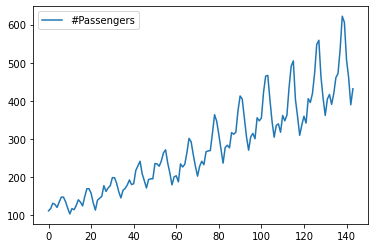

In [3]:
data.plot()

Notice that the x-axis has no label and doesn't seem to parse the month info.

Let's look at the datatypes:

In [4]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

`Month` is an object, but it should be a date. Let's convert it:

In [5]:
data_ind = pd.DatetimeIndex(data['Month'])
data_ind

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Now we need to set this as the index of the DataFrame:

In [6]:
data['Month'] = data_ind
data.set_index('Month', inplace=True)
print(data.dtypes)
data


#Passengers    int64
dtype: object


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Finally, let's plot it again:

<AxesSubplot:xlabel='Month'>

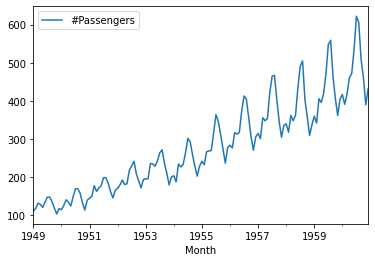

In [7]:
data.plot()

Notice how the month is now automatically annotated on the X-Axis, because we used the proper format.

In [8]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

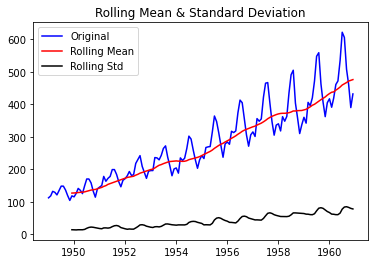

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
ts = data['#Passengers']
test_stationarity(ts)


#### Estimating & eliminating Trend

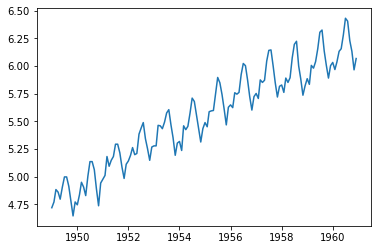

In [10]:
import numpy as np
ts_log = np.log(ts)
plt.plot(ts_log)

#### Moving average

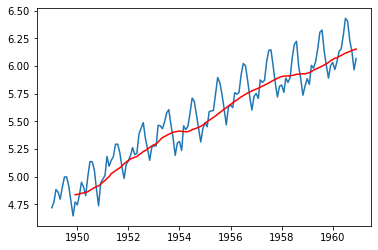

In [11]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

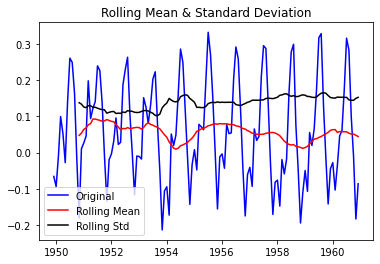

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

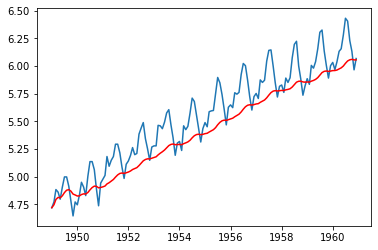

In [14]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

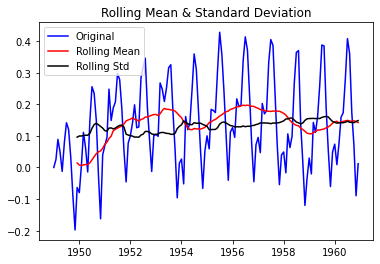

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

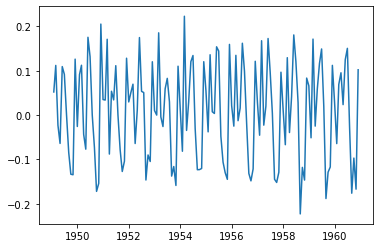

In [16]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

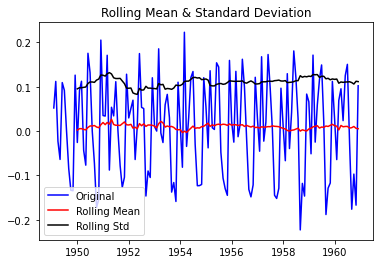

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

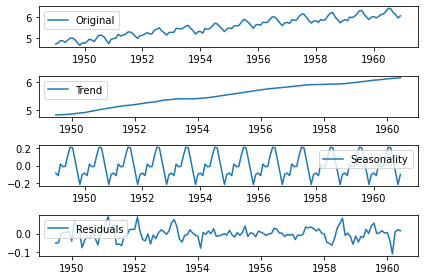

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

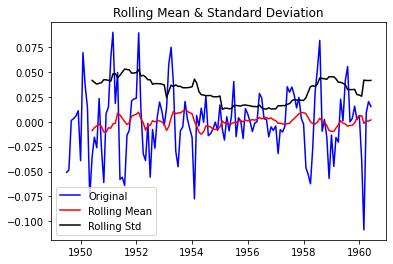

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Forecasting a Time Series

In [ ]:
### adding code for #ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

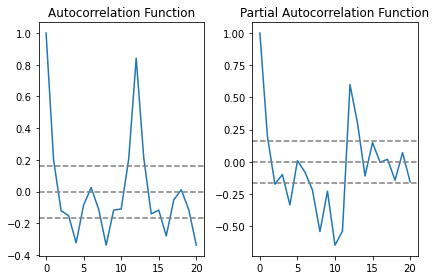

In [21]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [36]:
from statsmodels.tsa.arima.model import ARIMA

/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 1.5023')

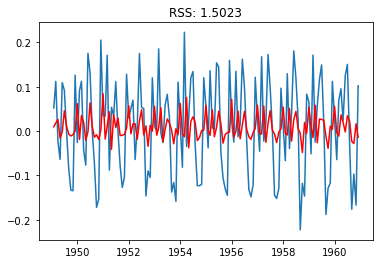

In [66]:
model = ARIMA(ts_log_diff, order=(2, 0, 0))  
results_AR = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((results_AR.fittedvalues-ts_log_diff)**2))

In [72]:
ts_log_diff

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Name: #Passengers, Length: 143, dtype: float64

/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: 1.4721')

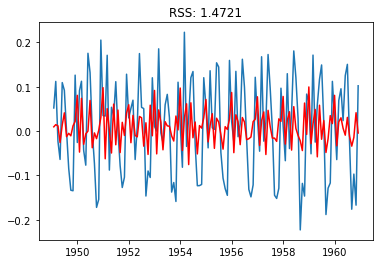

In [73]:
model = ARIMA(ts_log_diff, order=(0, 0, 2), freq='MS')  
results_MA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ms16aay/mambaforge/envs/teaching/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 1.2171')

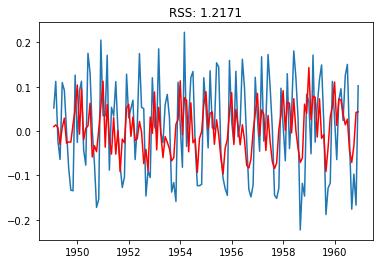

In [74]:
model = ARIMA(ts_log_diff, order=(2, 0, 2), freq='MS')  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [76]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.010053
1949-03-01    0.013847
1949-04-01    0.007587
1949-05-01   -0.030187
1949-06-01    0.008378
dtype: float64


In [77]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print( predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.010053
1949-03-01    0.023901
1949-04-01    0.031487
1949-05-01    0.001300
1949-06-01    0.009678
dtype: float64


In [78]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728552
1949-03-01    4.742399
1949-04-01    4.749986
1949-05-01    4.719799
dtype: float64

In [79]:
predictions_ARIMA.tail(20)

Month
1959-05-01    6.167842e+294
1959-06-01    2.682135e+297
1959-07-01    1.215119e+300
1959-08-01    6.627011e+302
1959-09-01    3.395886e+305
1959-10-01    1.497855e+308
1959-11-01              inf
1959-12-01              inf
1960-01-01              inf
1960-02-01              inf
1960-03-01              inf
1960-04-01              inf
1960-05-01              inf
1960-06-01              inf
1960-07-01              inf
1960-08-01              inf
1960-09-01              inf
1960-10-01              inf
1960-11-01              inf
1960-12-01              inf
dtype: float64

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))